In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spsp

## Partie 1. (Format Compressed Sparse Row)

1. Expliquez A.data, A.indptr, A.indices par $A$.

In [2]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])

A = spsp.csr_matrix((data, (row, col)), shape=(3, 3))
print("A.toarray() =\n", A.toarray())

A.toarray() =
 [[1 0 2]
 [0 0 3]
 [4 5 6]]


In [3]:
print(A.data) # Stocker tous les éléments non nuls par lignes.

[1 2 3 4 5 6]


In [4]:
print(A.indptr) # Les positions de début et de fin de chaque ligne dans A.data.

[0 2 3 6]


In [5]:
print(A.indices) # Stocke l'index de colonne correspondant à chaque élément non nul.

[0 2 2 0 1 2]


In [6]:
print(A) # A est le format CSR.

  (0, 0)	1
  (0, 2)	2
  (1, 2)	3
  (2, 0)	4
  (2, 1)	5
  (2, 2)	6


2. Opérer sur une colonne nécessite de parcourir toutes les lignes. Étant donné que le format CSR est stocké par ligne, il ne convient pas directement à une extraction efficace des colonnes.

In [7]:
print("A[0, :] =\n", A[0, :]) # Les opérations sur les lignes est rapid.

A[0, :] =
   (0, 0)	1
  (0, 2)	2


In [8]:
print("A[:, 0] =\n", A[:, 0]) # Les opérations sur les colonnes est lent。

A[:, 0] =
   (0, 0)	1
  (2, 0)	4


3. Si les matrices A et B ont des formes différentes, l’addition **ne peut pas** avoir lieu. Parce que le code suivant signale une **erreur**.

In [9]:
A1 = spsp.csr_matrix([[1, 0, 2, 1], [0, 0, 0, 9], [4, 5, 0, 8], [0, 2 ,0, 8]])
A2 = spsp.csr_matrix([[0, 2, 0], [3, 0, 4], [0, 0, 6]])

#A3 = A1 + A2
#print(A3.toarray())

4. Comparez les résultats de calcul de la fonction personnalisée `matvect_multiply` avec la fonction intégrée `A.dot(b)` ou `A @ b`.

In [10]:
def matvect_multiply(A, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
      row_start = A.indptr[i]
      row_end = A.indptr[i + 1]
      for k in range(row_start, row_end):
          j = A.indices[k]
          y[i] += A.data[k] * b[j]
    return y

# test
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
A = spsp.csr_matrix((data, (row, col)), shape=(3, 3))

b = np.random.rand(3)
print(b)

y_1 = matvect_multiply(A, b)
y_2 = A.dot(b)

print(y_1)
print(y_2)

difference = np.linalg.norm(y_1 - y_2)
print("difference: ", difference)

[0.07969588 0.19154653 0.60146658]
[1.28262904 1.80439974 4.88531569]
[1.28262904 1.80439974 4.88531569]
difference:  0.0


La fonction `np.dot(A, b)` génère une erreur car `np.dot` s'attend à une matrice dense, alors que `A` est une CSR. Il faut utiliser `A.dot(b)` pour effectuer la multiplication entre une matrice creuse et un vecteur.

## Partie 2. (Factorisation LU)

5. Pour écrire une fonction de décomposition LU sur place `Facto_LU(A)`, la matrice A doit être traitée ligne par ligne, en mettant à jour ses parties triangulaires inférieure et supérieure.

In [11]:
def Facto_LU(A):
    n = A.shape[0]
    for i in range(n):
        if A[i, i] == 0:
            return -1
        for j in range(i+1, n):
            A[j, i] = A[j, i] / A[i, i]
            A[j, i+1:] = A[j, i+1:] - A[j, i] * A[i, i+1:]
    return A

C = spsp.csr_matrix([[2, -1, -2],
                      [0, 6, 3],
                      [1, 0, 8]], dtype=float)

B = Facto_LU(C.copy())
print(B.toarray())

[[ 2.         -1.         -2.        ]
 [ 0.          6.          3.        ]
 [ 0.5         0.08333333  8.75      ]]


/home/lyric/anaconda3/envs/anaenv/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/lyric/anaconda3/envs/anaenv/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


6. Après avoir obtenu la décomposition **LU** de la matrice $A$, le système linéaire $Ax = b$ peut être résolu par substitution avant et substitution arrière.

In [12]:
def solve_LU(A, b):
    n = len(b)
    y = np.zeros(n)
    x = np.zeros(n)
    for i in range(n):
        sum_L = 0
        for k in range(i):
            sum_L += A[i, k]*y[k]
        y[i] = b[i] - sum_L

    for i in range(n-1, -1, -1):
        sum_U = 0
        for k in range(i+1, n):
            sum_U += A[i, k] * x[k]
        x[i] = (y[i] - sum_U) / A[i, i]

    return x

C = np.array([[2, -1, -2],
              [0, 3, 1],
              [0, 0, 8]], dtype=float)
b = np.array([1, 2, 3], dtype=float)

x = solve_LU(C, b)
print("x:\n", x)

x:
 [1.14583333 0.54166667 0.375     ]


7. Utilisez la matrice donnée dans l'exercice pour tester et comparer la différence entre ma propre implémentation et la solution calculée à l'aide du solveur linéaire sparse de Scipy, `spsolve`.

In [13]:
import scipy.sparse.linalg as spsplin

n = 5
A = spsp.diags([-np.ones(n-1), 2*np.ones(n), -np.ones(n-1)], [-1, 0, 1])
A = A.tocsr()

A_original = A.copy()

b = np.random.rand(n)

Facto_LU(A)

x_moi = solve_LU(A, b)

x_scipy = spsplin.spsolve(A_original, b)

print(x_moi)
print(x_scipy)

difference = np.linalg.norm(x_moi - x_scipy)
print("difference: ", difference)

[1.86410013 2.80834663 2.86771876 2.58767123 1.38504234]
[1.86410013 2.80834663 2.86771876 2.58767123 1.38504234]
difference:  1.2560739669470201e-15


## Partie 3 (Remplissage - fill in).

8. 矩阵 $A$, $B$ 的形式为：

$$
A = \begin{pmatrix}
\alpha & 1 & 1 & \dots & 1 \\
1 & 1 & 0 & \dots & 0 \\
1 & 0 & 1 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & 0 & 0 & \dots & 1 \\
\end{pmatrix},\quad
B = \begin{pmatrix}
1 & 0 & 0 & \dots & 1 \\
0 & 1 & 0 & \dots & 1 \\
0 & 0 & 1 & \dots & 1 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & 1 & 1 & \dots & \alpha \\
\end{pmatrix}
$$

- **矩阵 $A$**： $\alpha \notin \{0, 1, 2, \dots, n - 1\}$

- **矩阵 $B$**： $\alpha \neq n - 1$

9. Utilisez DOK pour créer les matrices ci-dessus, puis convertissez-les au format CSR.

In [14]:
n = 10

alpha = 7

A_dok = spsp.dok_matrix((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            A_dok[i, j] = 1
        elif i == 0:
            A_dok[i, j] = 1
        elif j == 0:
            A_dok[i, j] = 1
A_dok[0, 0] = alpha

A_csr = A_dok.tocsr()

print("Matrix A in CSR format:\n", A_csr.toarray())

B_dok = spsp.dok_matrix((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            B_dok[i, j] = 1
        elif j == n - 1:
            B_dok[i, j] = 1
        elif i == n - 1:
            B_dok[i, j] = 1
B_dok[n-1, n-1] = alpha

B_csr = B_dok.tocsr()

print("Matrix B in CSR format:\n", B_csr.toarray())

Matrix A in CSR format:
 [[7. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Matrix B in CSR format:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 7.]]


10. Utilisez la commande `spy` de matplotlib pour observer la structure de la matrice avant et après la décomposition LU.

/tmp/ipykernel_21551/617076022.py:5: SparseEfficiencyWarning: splu converted its input to CSC format
  lu_A = splu(A_csr)
/tmp/ipykernel_21551/617076022.py:8: SparseEfficiencyWarning: splu converted its input to CSC format
  lu_B = splu(B_csr)


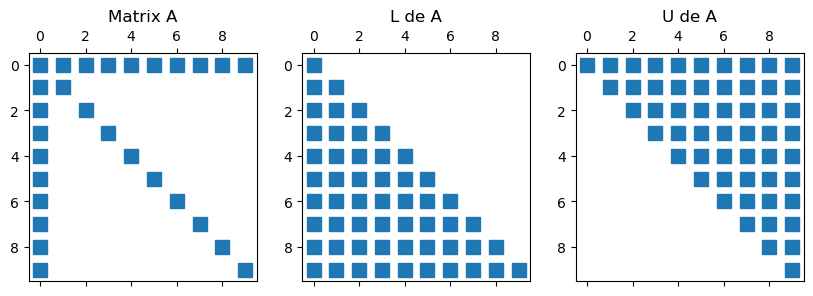

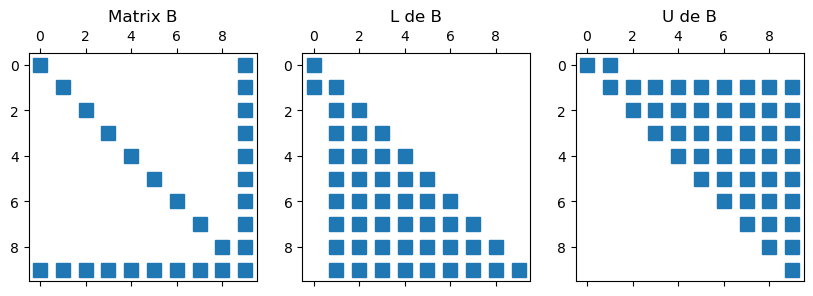

In [15]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import splu

# Perform LU decomposition on A
lu_A = splu(A_csr)

# Perform LU decomposition on B
lu_B = splu(B_csr)

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('Matrix A')
plt.spy(A_csr)

plt.subplot(1, 3, 2)
plt.title('L de A')
plt.spy(lu_A.L)

plt.subplot(1, 3, 3)
plt.title('U de A')
plt.spy(lu_A.U)
plt.show()


plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('Matrix B')
plt.spy(B_csr)

plt.subplot(1, 3, 2)
plt.title('L de B')
plt.spy(lu_B.L)

plt.subplot(1, 3, 3)
plt.title('U de B')
plt.spy(lu_B.U)
plt.show()

Le CSR de la matrice d'origine ne peut pas être conservé sous décomposition LU.

## Partie 4 (temps de calcul).

11. Générez une matrice basée sur la question. Utilisez `spdiags`.

In [16]:
from scipy.sparse import spdiags

d = 4
n = d ** 2

main_diag = 4 * np.ones(n)
diag_1 = -1 * np.ones(n)
diag_d = -1 * np.ones(n)

diagonals = [main_diag, diag_1, diag_1, diag_d, diag_d]
positions = [0, 1, -1, d, -d]

matrix1 = spdiags(diagonals, positions, n, n)

M = matrix1.tocsr()
print(M.toarray())

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. 

12. Utilisez le module time pour comparer le temps de calcul de la fonction `Facto_LU` que j'ai écrite lors de la décomposition de la matrice donnée et de sa version dense.

In [17]:
import time

M_sparse = M.copy()

start_time_sparse = time.time()
Facto_LU(M_sparse)
end_time_sparse = time.time()
print("(LU) time_sparse = ", end_time_sparse - start_time_sparse, "s")

M_dense = M.toarray()

start_time_dense = time.time()
Facto_LU(M_dense)
end_time_dense = time.time()
print("(LU) time_dense  = ", end_time_dense - start_time_dense, "s")

(LU) time_sparse =  0.06720995903015137 s
(LU) time_dense  =  0.0006909370422363281 s


/home/lyric/anaconda3/envs/anaenv/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/lyric/anaconda3/envs/anaenv/lib/python3.11/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Bien que, en général, les matrices creuses soient plus rapides, dans cet exemple, il est probable que de nombreux fill-ins doivent être effectués, ce qui nécessite plus de temps.

13. Utilisez le module time pour comparer le temps de calcul de la fonction `splu` de scipy lors de la décomposition de la matrice donnée et de sa version dense.

In [18]:
from scipy.sparse.linalg import splu
from scipy.linalg import lu

start_time_splu_sparse = time.time()
lu_sparse = splu(M_sparse)
end_time_splu_sparse = time.time()
print("(splu) time_sparse = ", end_time_splu_sparse - start_time_splu_sparse, "s")

start_time_splu_dense = time.time()
P, L, U = lu(M_dense)
end_time_splu_dense = time.time()
print("( lu ) time_dense  = ", end_time_splu_dense - start_time_splu_dense, "s")

(splu) time_sparse =  0.0011587142944335938 s
( lu ) time_dense  =  0.0004563331604003906 s


/tmp/ipykernel_21551/1019851924.py:5: SparseEfficiencyWarning: splu converted its input to CSC format
  lu_sparse = splu(M_sparse)


Comme avec le résultat obtenu par ma fonction, la matrice dense est également plus rapide. Cependant, la fonction `splu` est bien plus efficace que la mienne.